# Ajustes de la catenaria

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# 3D Libs
import open3d as o3d
import laspy
print(laspy.__version__)

# Geospatial libs
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh    

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3


In [2]:
def get_coord(points):
    
    x_vals = [punto[0] for punto in points]
    y_vals = [punto[1] for punto in points]
    z_vals = [punto[2] for punto in points]
    
    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def get_coord2(extremos_apoyos):
    
    x_vals = [extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"]]
    y_vals = [extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"]]
    z_vals = extremos_apoyos[0]["COORDENADAS_Z"] + extremos_apoyos[1]["COORDENADAS_Z"]

    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def unravel_data_element(element):
    
    for key in element.keys():
    
        if type(element[key]) in [list, dict]:
            
            print(f"\n{key}: ")
            
            if type(element[key]) == list:
            
                element2 = element[key][0]
                print(f"- Length of list: {len(element[key])}")
                
            else:
                
                element2 = element[key]
            
            for key2 in element2.keys():
                
                print(f"    {key2}: {element2[key2]}")
                
                if type(element2[key2]) == list:
                    print(f"    - Length of list: {len(element2[key2])}")
        
        else:
            print(f"\n{key}: {element[key]}")

Obtenemos los datos de los 3 archivos

In [3]:
import json

path = "../data/"

with open(path+'vanos.json', 'r') as archivo:
    data1 = json.load(archivo)

with open(path+'datos1.json', 'r') as archivo:
    data2 = json.load(archivo)

with open(path+'datos2.json', 'r') as archivo:
    data3 = json.load(archivo)

Matriz de rotación

In [4]:
def rotate_points(points, extremos_values):
    
    points = np.array(points).T

    extremo1 = np.array(extremos_values).T[0]  # Extremo superior del primer poste
    extremo2 = np.array(extremos_values).T[2]  # Extremo inferior del primer poste
    
    # Calcular la distancia en el plano XY y la dirección de la diagonal
    distancia_xy = np.linalg.norm(extremo2[:2] - extremo1[:2])
    direccion_diagonal = (extremo2[:2] - extremo1[:2]) / distancia_xy # Normalizada para la distancia
    
    # Calcular el ángulo de rotación necesario para alinear la diagonal con el eje Y
    angulo = np.arctan2(direccion_diagonal[1], direccion_diagonal[0])
    
    # Ajustar el ángulo para la rotación correcta
    angulo += np.pi / 2
    c, s = np.cos(angulo), np.sin(angulo)
    
    # Crear la matriz de rotación para alinear la diagonal con el eje Y
    matriz_rotacion = np.array([[c, s, 0],
                                [-s, c, 0],
                                [0, 0, 1]])
    
    rotated_points = matriz_rotacion.dot(points.T)
    # print(rotated.shape)
    
    return matriz_rotacion, np.array(rotated_points)

Ajuste

In [5]:
def ajuste(data, vano):
    puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
    puntos_vertices = data[vano]['CONDUCTORES'][0]['VERTICES']
    puntos_vertices2 = data[vano]['CONDUCTORES'][1]['VERTICES']
    puntos_vertices3 = data[vano]['CONDUCTORES'][2]['VERTICES']
    puntos_extremos = data[vano]['APOYOS']

    x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
    x_vals_extremos, y_vals_extremos, z_vals_extremos = get_coord2(puntos_extremos)
    x_vert1, y_vert1, z_vert1 = get_coord(puntos_vertices)
    x_vert2, y_vert2, z_vert2 = get_coord(puntos_vertices2)
    x_vert3, y_vert3, z_vert3 = get_coord(puntos_vertices3)

    cond_values = [x_vals_conductores, y_vals_conductores, z_vals_conductores]
    extremos_values = [x_vals_extremos, y_vals_extremos, z_vals_extremos]
    vert_values1 = [x_vert1, y_vert1, z_vert1]
    vert_values2 = [x_vert2, y_vert2, z_vert2]
    vert_values3 = [x_vert3, y_vert3, z_vert3]

    # Rotamos los puntos pare ver el perfil del vano
    mat, rotated_conds = rotate_points(cond_values, extremos_values)
    extremos_values = mat.dot(extremos_values)
    rotated_vertices1 = mat.dot(vert_values1)
    rotated_vertices2 = mat.dot(vert_values2)
    rotated_vertices3 = mat.dot(vert_values3)

    X_extremos = extremos_values[0]
    Y_extremos = extremos_values[1]
    Z_extremos = extremos_values[2]

    X_cond = rotated_conds[0]
    Y_cond = rotated_conds[1]
    Z_cond = rotated_conds[2]

    # Filtramos los puntos que estén entre los extremos
    x = []
    y = []
    z = []

    for i in range(len(X_cond)):
        if Y_cond[i] > np.min(Y_extremos) and Y_cond[i] < np.max(Y_extremos):
            x.append(X_cond[i])
            y.append(Y_cond[i])
            z.append(Z_cond[i])

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    data_2d_cond = np.column_stack((y, z))

    pca = PCA(n_components=2)
    data_2d_pca_cond = pca.fit_transform(data_2d_cond)

    y_min_cond, y_max_cond = data_2d_pca_cond[:, 1].min(), data_2d_pca_cond[:,1].max()

    f_ind = (data_2d_pca_cond[:,1] > y_min_cond) & (data_2d_pca_cond[:,1] < y_max_cond)
    x_filt_cond, y_filt_cond, z_filt_cond = x[f_ind], y[f_ind], z[f_ind]

    # Función de la catenaria
    from sklearn.preprocessing import StandardScaler
    from scipy.optimize import curve_fit
    def catenaria(x, a, h, k):
        return a*np.cosh((x-h)/a)+k

    y_vals = y_filt_cond.reshape(-1, 1)
    z_vals = z_filt_cond.reshape(-1, 1)

    scaler_y = StandardScaler()
    scaler_z = StandardScaler()

    y_vals_scaled = scaler_y.fit_transform(y_vals).flatten()
    z_vals_scaled = scaler_z.fit_transform(z_vals).flatten()

    p0 = [1, 0, 0]

    parametros, _ = curve_fit(catenaria, y_vals_scaled.flatten(), z_vals_scaled)

    # Ajuste de los puntos de los datos a una catenaria
    fitted_z_vals_scaled = catenaria(y_vals_scaled.flatten(), *parametros)
    fitted_z_vals = scaler_z.inverse_transform(fitted_z_vals_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(10, 6))
    plt.scatter(y, z, label='Datos', s=30)
    plt.scatter(scaler_y.inverse_transform(y_vals_scaled.reshape(-1, 1)).flatten(), fitted_z_vals, color='red', label='Ajuste', s=5)

    # Polilínea que nos proporcionan con los datos
    plt.plot(rotated_vertices1[1], rotated_vertices1[2], "-o", color='green', label='Polilínea_datos')
    plt.plot(rotated_vertices2[1], rotated_vertices2[2], "-o", color='green')
    plt.plot(rotated_vertices3[1], rotated_vertices3[2], "-o", color='green')

    # Interpolación de la polilínea
    minimo = np.min(scaler_y.inverse_transform(y_vals_scaled.reshape(-1, 1)).flatten())
    maximo = np.max(scaler_y.inverse_transform(y_vals_scaled.reshape(-1, 1)).flatten())
    x_pol = np.linspace(minimo, maximo, 1000)

    scaler_x = StandardScaler()

    x_scaled = scaler_x.fit_transform(x_pol.reshape(-1, 1)).flatten()

    fitted_y_scaled = catenaria(x_scaled.flatten(), *parametros)
    fitted_y = scaler_z.inverse_transform(fitted_y_scaled.reshape(-1, 1)).flatten()

    y2 = np.interp(x_pol, scaler_y.inverse_transform(y_vals_scaled.reshape(-1, 1)).flatten(), fitted_z_vals, period=len(fitted_z_vals))

    plt.plot(x_pol, y2, color='black', label='Polilínea')

    plt.legend()
    plt.title(vano)

Función para ver los vanos en 3D

In [6]:
def grafica(data, vano):
    puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
    puntos_apoyos = data[vano]['LIDAR']['APOYOS']

    extremos_apoyos = data[vano]['APOYOS']

    x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
    x_vals_apoyos, y_vals_apoyos, z_vals_apoyos = get_coord(puntos_apoyos)

    xyz_cond = np.vstack((np.concatenate([x_vals_conductores, x_vals_apoyos]), 
            np.concatenate([y_vals_conductores, y_vals_apoyos]), np.concatenate([z_vals_conductores, z_vals_apoyos])))

    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(xyz_cond.transpose())

    pcd_center = pcd_o3d.get_center()
    pcd_o3d.translate(-pcd_center)

    o3d.visualization.draw_plotly([pcd_o3d])

Vanos que resultan interesantes para el ajuste

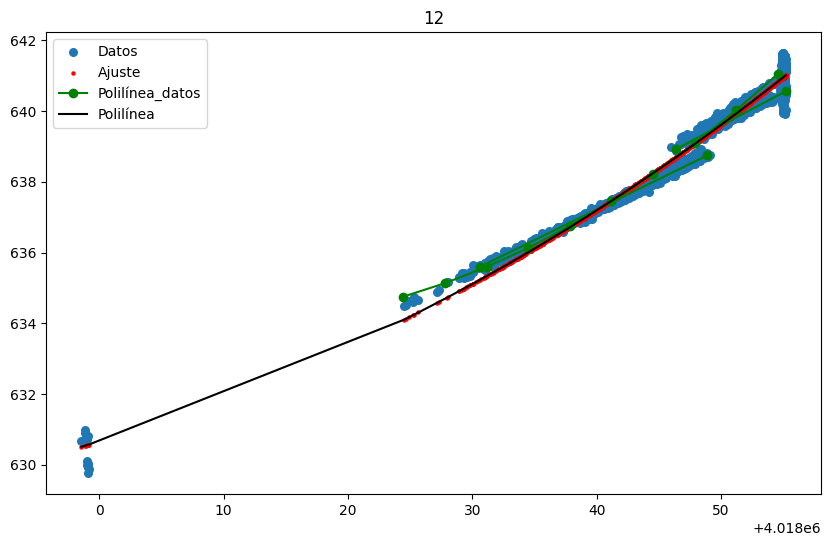

In [7]:
ajuste(data1, 12)

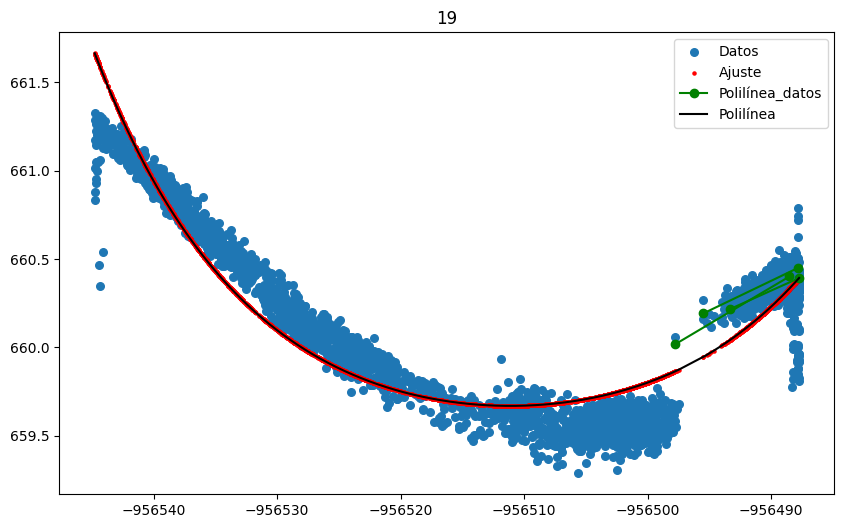

In [8]:
ajuste(data1, 19)

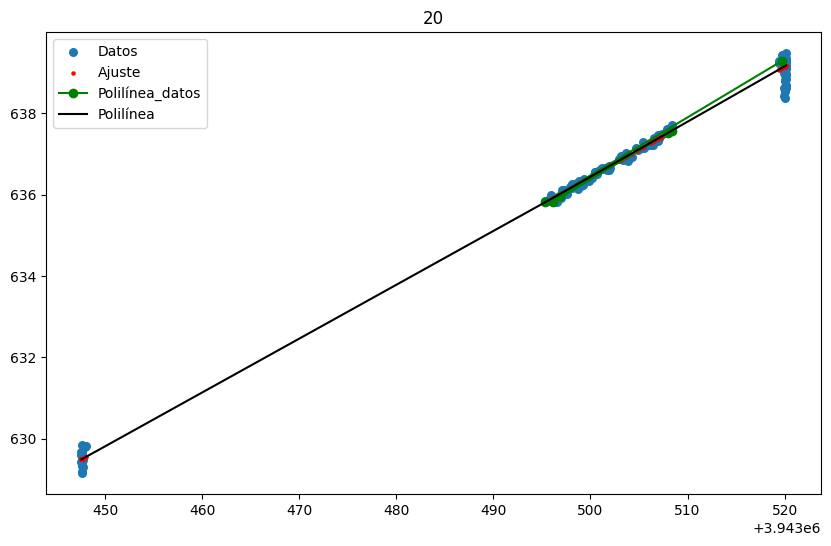

In [9]:
ajuste(data1, 20)

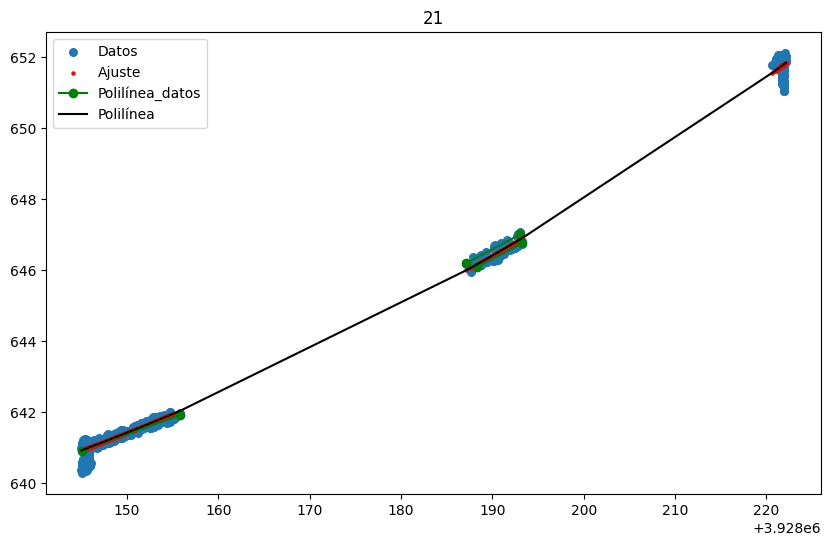

In [10]:
ajuste(data1, 21)

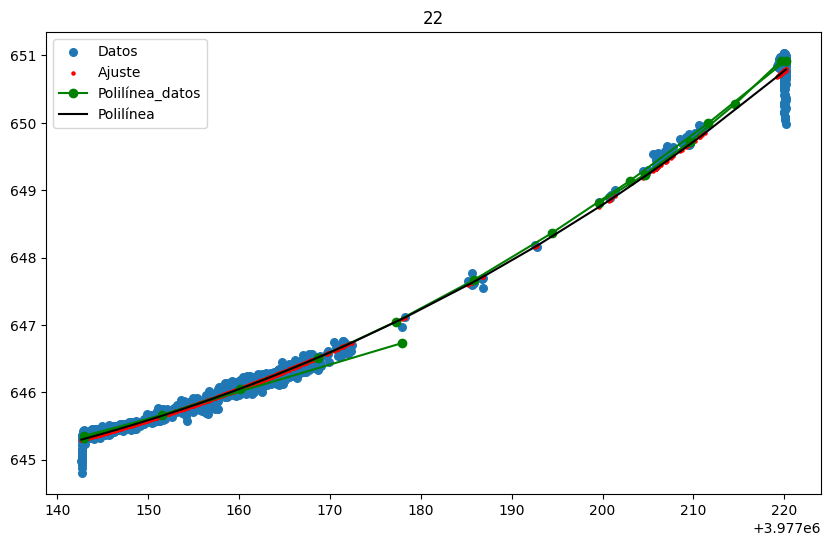

In [11]:
ajuste(data1, 22)

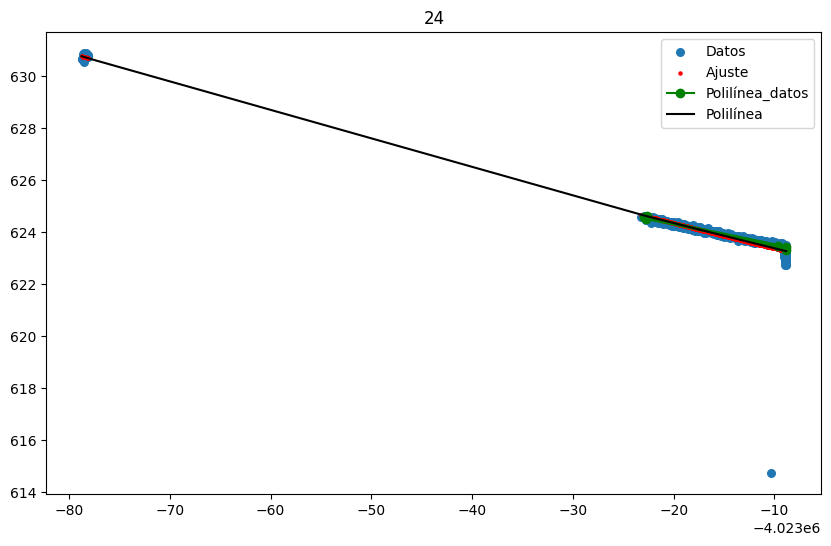

In [12]:
ajuste(data1, 24)

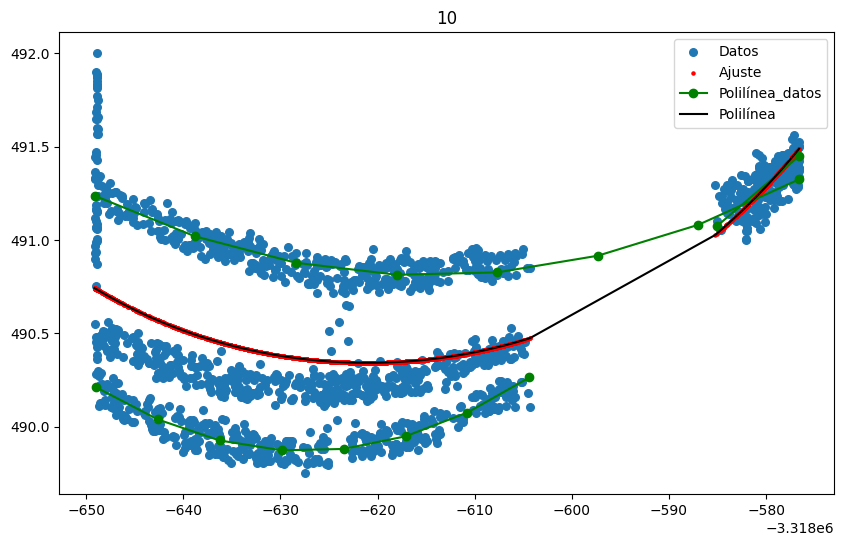

In [13]:
ajuste(data2, 10)

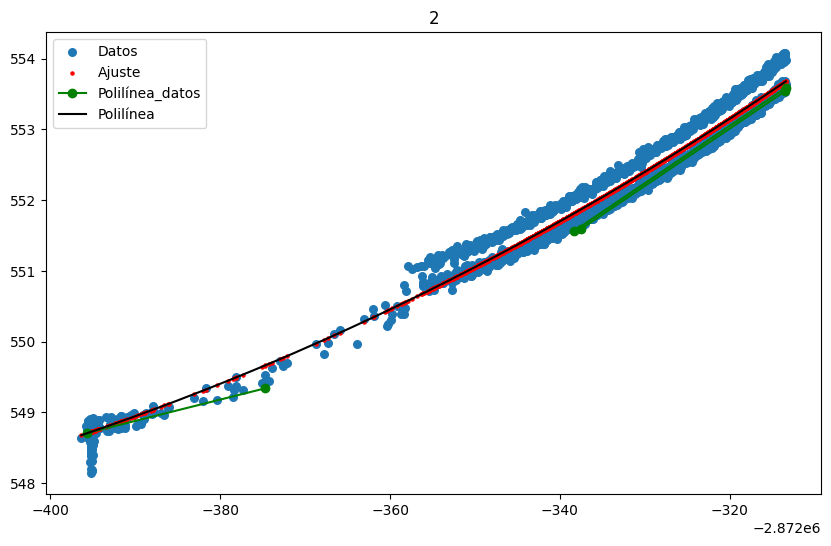

In [14]:
ajuste(data3, 2)

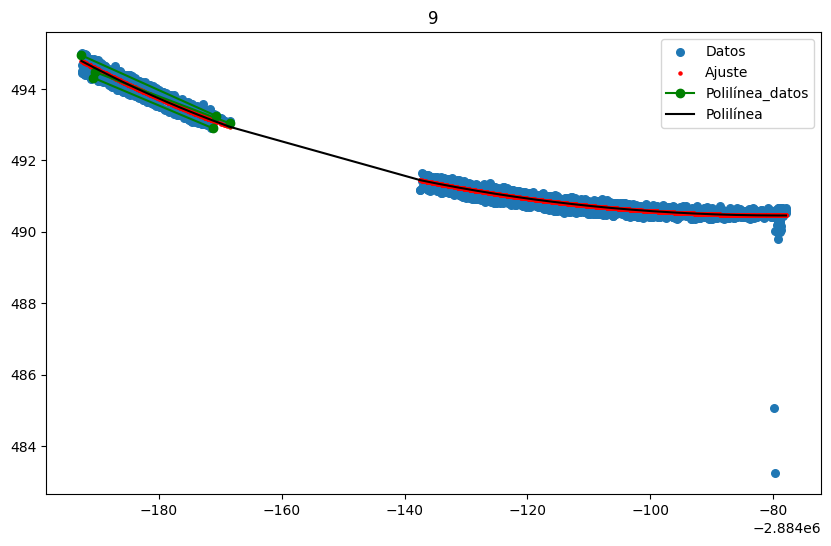

In [15]:
ajuste(data3, 9)

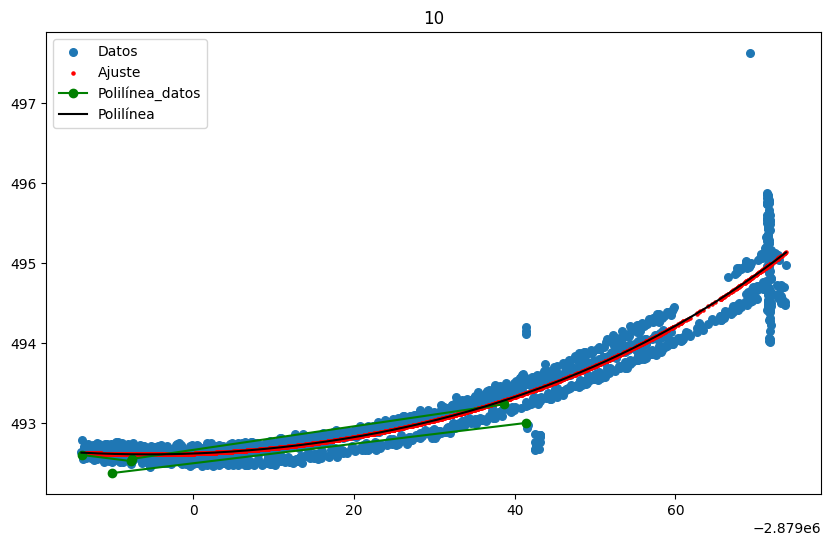

In [16]:
ajuste(data3, 10)